In [ ]:
%load_ext autoreload
%load_ext autotime

time: 176 µs (started: 2024-12-12 22:31:10 -08:00)


In [2]:
import os
import sys
import time
import warnings
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 687 ms (started: 2024-12-12 22:31:11 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46423"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.65 ms (started: 2024-12-12 22:31:13 -08:00)


In [4]:
# Parameters
analyzer = "dftracer"
# app_view_types = ["proc_name", "time_range"]
bottleneck_dir = "/p/lustre3/iopp/wisio-bottlenecks/dftracer-unet3d-dlio-v100-node-16-v2-proc_name-time_range"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-unet3d-dlio-v100-node-16-v2-proc_name-time_range"
cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:36047"
# dataloader_view_types = ["proc_name", "time_range"]
logical_view_types = False
output_max_bottlenecks = 3
output_root_only = False
percentile = 0.6
# posix_view_types = ["proc_name", "time_range"]
run_dir = ".wisio/dftracer-unet3d-dlio-v100-node-16-v2-proc_name-time_range"
# time_granularity = 4000000.0
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/unet3d/dlio-v100/node-16/v2/RAW/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]

time: 1.17 ms (started: 2024-12-12 22:31:33 -08:00)


In [5]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={time_granularity}",
            # f"cluster={cluster}",
            # f"cluster.restart_on_connect={cluster_restart_on_connect}",
            # f"cluster.scheduler_address={cluster_scheduler_address}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.compact={output_compact}",
            f"output.group_behavior={output_group_behavior}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
        if cluster.restart_on_connect:
            client.restart()
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 3.1 s (started: 2024-12-12 22:31:39 -08:00)


In [6]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 6.03 ms (started: 2024-12-12 22:31:42 -08:00)


In [7]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=0 threads=0, memory=0 B>

time: 2.95 s (started: 2024-12-12 22:31:42 -08:00)


In [8]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 1min 20s (started: 2024-12-12 22:31:47 -08:00)


In [9]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 563 µs (started: 2024-12-12 22:33:07 -08:00)


In [10]:
checkpoint_dir

'/p/lustre3/iopp/wisio-checkpoints/dftracer-unet3d-dlio-v100-node-16-v2-proc_name-time_range'

time: 1.57 ms (started: 2024-12-12 22:33:07 -08:00)


In [15]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 3.77 s (started: 2024-12-12 22:33:18 -08:00)


In [11]:
flat_views[('time_range',)].sort_index().to_csv('unet3d_node16_time_range.csv')

time: 68.7 ms (started: 2024-12-12 22:33:12 -08:00)


In [12]:
flat_views[('proc_name',)].sort_index().to_csv('unet3d_node16_proc_name.csv')

time: 913 ms (started: 2024-12-12 22:33:12 -08:00)


In [13]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('unet3d_node16_host_name.csv')

time: 52 ms (started: 2024-12-12 22:33:13 -08:00)


In [14]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('unet3d_node16_proc_id.csv')

time: 80.9 ms (started: 2024-12-12 22:33:13 -08:00)


In [14]:
import pandas as pd

df3 = pd.read_csv('unet3d_node16_proc_name.csv')

time: 76.9 ms (started: 2024-12-02 10:41:52 -08:00)


<Axes: >

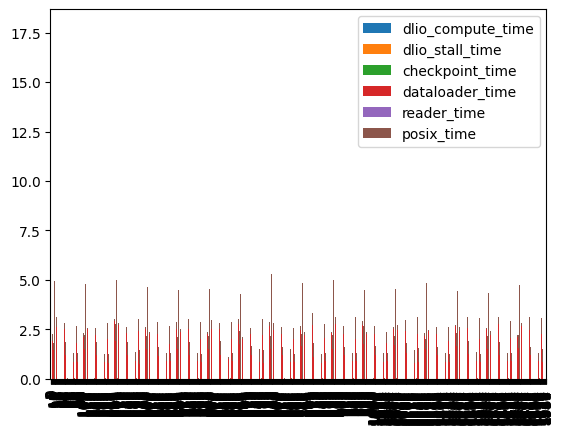

time: 19.3 s (started: 2024-12-02 10:42:19 -08:00)


In [19]:
df3.sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='bar', stacked=True) # .plot(kind='area', ylim=(0, 6))

<Axes: >

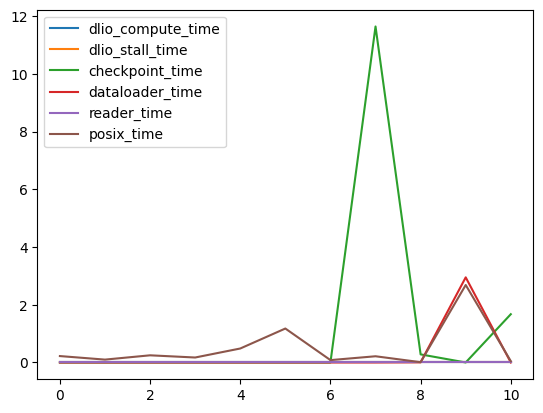

time: 182 ms (started: 2024-12-02 10:41:53 -08:00)


In [16]:
pd.read_csv('unet3d_node16_time_range.csv').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot()

In [8]:
analyzer.write_bottlenecks(result.flat_bottlenecks)

time: 554 ms (started: 2024-11-11 10:16:40 -08:00)


In [9]:
output.handle_result(metrics=[], result=result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 51.55 seconds (100%)                                                                        │
│            ├── Application I/O Time: 0.84 seconds (1.62%)                                                       │
│            ├── Checkpoint I/O Time: 0.84 seconds (1.62%)                                                        │
│            ├── Compute Time: 0.00 seconds (0.00%)                                                               │
│            ├── I/O Time: 5.44 seconds (10.55%)                                                                  │
│            ├── Read I/O Time: 0.00 seconds (0.00%)                                                              │
│            ├── Time: 19.93 seconds (38.66%)                                                                     │
│            ├── Unoverlapped Application I/O Time: 0.84 seconds (1.62%)                                          │
│            ├── Unoverlapped Checkpoint I/O Time: 0.84 seconds (1.62%)                                           │
│            ├── Unoverlapped Compute Time: 0.00 seconds (0.00%)                                                  │
│            ├── Unoverlapped I/O Time: 5.44 seconds (10.55%)                                                     │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 0.00 seconds (0.00%)                                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭──────────────────────────────────────── DATALOADER I/O Characteristics ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime         51.55 seconds                                                                                  │
│  I/O Time        5.44 seconds (100%)                                                                            │
│                  ├── Read: 0.30 seconds (5.45%)                                                                 │
│                  ├── Write: 0.00 seconds (0.01%)                                                                │
│                  └── Metadata: 5.14 seconds (94.39%)                                                            │
│  I/O Ops.        10,505,221 ops                                                                                 │
│                  ├── Read - 267,648 ops (2.55%)                                                                 │
│                  ├── Write - 4,003 ops (0.04%)                                                                  │
│                  └── Metadata - 10,059,714 ops (95.76%)                                                         │
│  I/O Size        715.55 MiB                           

time: 44.2 ms (started: 2024-11-11 10:16:42 -08:00)


In [10]:
bottlenecks = analyzer.read_bottlenecks()

time: 25.6 ms (started: 2024-11-11 09:28:22 -08:00)


In [11]:
from bokeh.io import show
from wisio.plots import plot_bottleneck_summary

show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name')))

time: 613 ms (started: 2024-11-11 09:28:24 -08:00)


In [12]:
show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name', 'metric')))

time: 546 ms (started: 2024-11-11 09:28:28 -08:00)


In [20]:
bot_tr = bottlenecks.query('layer == "APP" & view_name == "time_range" & view_depth == 1')
# bot_tr.compute()
show(plot_bottleneck_summary(bot_tr, groupby=('view_name', 'subject')))

time: 673 ms (started: 2024-11-11 09:30:52 -08:00)


In [10]:
result.main_views['DATALOADER'].head()

app_io_time  checkpoint_io_time  \
proc_name                   time_range                                    
app#corona189#183852#183852 0                   0.0                 0.0   
                            1                   0.0                 0.0   
                            4                   0.0                 0.0   
                            5                   0.0                 0.0   
                            6                   0.0                 0.0   

                                        compute_time   io_time  read_io_time  \
proc_name                   time_range                                         
app#corona189#183852#183852 0                    0.0  0.201842           0.0   
                            1                    0.0  0.073676           0.0   
                            4                    0.0  0.238899           0.0   
                            5                    0.0  0.164962           0.0   
                            6                    0.0  0.468485           0.0   

                                            time  count  size_min  size_max  \
proc_name                   time_range                                        
app#corona189#183852#183852 0           0.201842  10071        22     30693   
                            1           0.073676   2006        26       454   
                            4           0.238899   3982       976     65536   
                            5           0.164962   2686       120     65536   
                            6           0.468485  10746       120      1809   

                                           size  ...  u_metadata_time  \
proc_name                   time_range           ...                    
app#corona189#183852#183852 0            147974  ...         0.180073   
                            1              4911  ...         0.025729   
                            4           2671174  ...         0.198577   
                            5            592964  ...         0.153054   
                            6              1929  ...         0.467764   

                                        u_data_time  u_sequential_time  \
proc_name                   time_range                                   
app#corona189#183852#183852 0              0.018548           0.018548   
                            1              0.003249           0.003249   
                            4              0.040322           0.040322   
                            5              0.010492           0.010492   
                            6              0.000012           0.000012   

                                        u_random_time  u_close_time  \
proc_name                   time_range                                
app#corona189#183852#183852 0                     0.0      0.000099   
                            1                     0.0      0.002483   
                            4                     0.0      0.000275   
                            5                     0.0      0.000077   
                            6                     0.0      0.000007   

                                        u_open_time  u_seek_time  u_stat_time  \
proc_name                   time_range                                          
app#corona189#183852#183852 0              0.006613     0.000024     0.112441   
                            1              0.045697     0.000000     0.015627   
                            4              0.078935     0.000068     0.059810   
                            5              0.020225     0.000018     0.043212   
                            6              0.000878     0.000004     0.371306   

                                        u_app_compute_time  \
proc_name                   time_range                       
app#corona189#183852#183852 0                          0.0   
                            1                          0.0   
                            4                         

time: 65.2 ms (started: 2024-11-11 09:44:19 -08:00)
